In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib notebook

In [2]:
# simulation time
sim_time = 20
time_step = 1

In [3]:
# giu' su sinistra destra
colummella = [8,8,12,12]
# if in future we want to add lateral pin we already have everything set
epidermal_l, epidermal_r = [0,8,0,0], [0,8,0,0]
# if we want to add the last 5 cells to be longer this needs fix (grieneisen 2007 fig 1)
border_l, border_r = [8,0,0,12], [8,0,12,0]
vascular = [8,0,0,0]

P_out = np.zeros((22,12,4))

# 22 rows, 12 columns. The first is the upmost cell in the tip

# cinta esterna della radice (muraria)
P_out[0,:,:]=[0,0,0,0]
P_out[-1,:,:]=[0,0,0,0]
P_out[:,0,:]=[0,0,0,0]
P_out[:,-1,:]=[0,0,0,0]

# in futuro aggiungeremo un flusso di auxina dallo shoot

# defining colummellas
P_out[1:4,1:11] = colummella

# defining epidermal
P_out[4:21,1:3] = epidermal_l
P_out[4:21,9:11] = epidermal_r

# defining border
P_out[4:21,3] = border_l
P_out[4:21,8] = border_r

# defining vascular
P_out[4:21,4:8] = vascular

# defining QC in position [4,4:8] same PIN settings as vascular
#defining directions 0 is down, 1 is up, 2 is left, 3 is right

directions = [0, 1, 2, 3]

In [4]:
def update_2D(cells, source=(4,4), source_val=10, D=0.5, T=0.5, P_out=P_out, decay=0.000005):
    """
    updates vector of cells following equation (1)
    
    WORKS ONLY FOR 1D MODELS
    
    cells : numpy array, set of cells to simulate
    source : int, index of QC cell
    source_val : float, amount of auxin produced at every step by the QC cell
    D : float, diffusion rate of auxin
    T : float, PIN1-mediated transport rate
    P_out : numpy matrix (lenght,width,4), amount of PIN1 that a cell outtakes to every neighbour (down, up, left, right)
    """
    # define neighbours
    v = np.array([[-1,0], [1,0], [0,-1], [0,1]])
    updated_cells = np.zeros((len(cells),12))
    cells_flux = np.zeros((len(cells),12))
    for i, value in enumerate(cells[1:20], 1):
        step = np.zeros(cells.shape[1])
        step_direction_flux = np.zeros(cells.shape[1])
        for j in range(1,len(cells[i])-1):
            neighbours = [cells[k] for k in tuple(map(tuple, v + [i,j]))]
            
            diffusion_in = D*(sum(neighbours))
            diffusion_out = -(1/2.5)*D*value[j]*len(neighbours)
            aux_decay = -decay*value[j]

            transport_in = T*np.dot(P_out[i,j,:],neighbours)
            transport_out = -T*sum(P_out[i,j,:])*value[j]
    
            transport_out_down = -T*P_out[i,j,0]*value[j] ##divide the output of the transport depending on the direction
            transport_out_up =  -T*P_out[i,j,1]*value[j]
            transport_out_left =  -T*P_out[i,j,2]*value[j]
            transport_out_right = -T*P_out[i,j,3]*value[j]
            
            x_coord = (transport_out_left-transport_out_right)+1 ## coordinates definition (+1 to avoid errors)
            y_coord = (transport_out_up-transport_out_down)+1
            
            
            angle = (np.arctan(y_coord/x_coord)*180)//np.pi # polar coordinates angle defined and converted into degrees approximated to integer
            
            
            # last piece is the basal auxin production of each cell (a.u./(micrometers^2*sec))
            step[j] = value[j] + transport_in + transport_out + diffusion_in + diffusion_out + aux_decay + 16*24*0.0005
            step_direction_flux[j] = angle*120
            #           still not working without this piece
#             if step[j] <= 0:
#                 step[j] = 0

        updated_cells[i,:] = [0] + step + [0]
        cells_flux[i,:] = [0] + step_direction_flux + [0]
    updated_cells[source[0], source[1]:source[1]+4] += source_val*16*24
    return updated_cells,cells_flux

<IPython.core.display.Javascript object>


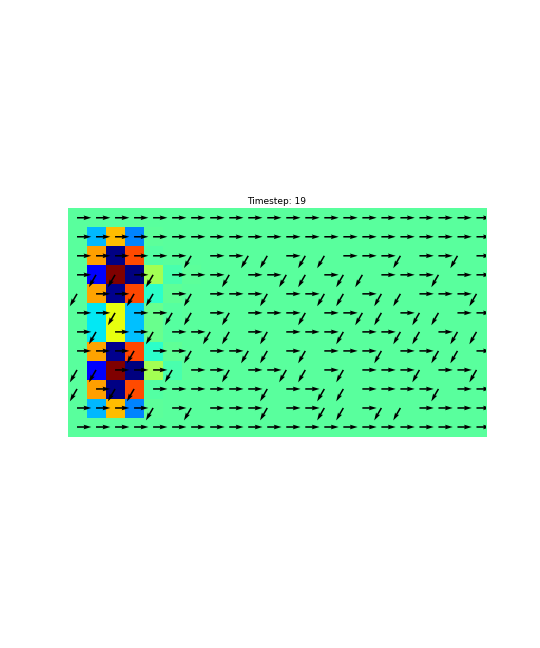

In [12]:
%matplotlib notebook
# number of cells within one single tissue
cells_a = np.ones((22,12))*20
cells_a[0,:]=0
cells_a[-1,:]=20
cells_a[:,0]=0
cells_a[:,-1]=0
# QC cell starts with an initial amount of auxin
#cells_a[3][1] = 10
cells_a[4,4:8] = 40
fig= plt.figure(figsize=(10,12)) #common canvas for any figure
plt.ion()
plt.title('Time: Beginning')
plt.axis('off')
plt.imshow(cells_a.T, cmap="jet")
cells_out = cells_a


X = np.repeat(1, 22)     ## X,Y are necessary to the definition of a grid that describes the arrow lenght
Y = np.repeat(1, 12)
U, V = np.meshgrid(X, Y)

times = np.arange(0, sim_time, time_step)   

for t in times:
    cells_out, cells_fluxes = update_2D(cells_out)
    #print(cells_fluxes)
    plt.imshow(cells_out.T, cmap="jet")
    plt.quiver(U, V, angles = cells_fluxes)
    plt.title(f"Timestep: {str(t)}")
    plt.axis('off')
    fig.canvas.draw()
    fig.canvas.flush_events()
    if t != times[-1]:
        plt.clf() ##to avoid the clearance of the plot


In [88]:
90/7

12.857142857142858

D and T are not working as we can't find a proper way to define them and find an equivalent in the literature. 

TODO:
create a flux model (see grieneisen 2007 Fig 2c) to see whether we can recover a reverse fountain loop (or where where doing it wrong!) 